In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')
    
def lossGraph(train_epoch_loss, test_epoch_loss, appendix='-'):
    fig, ax = plt.subplots(facecolor = 'white') 
    x = np.arange(1, len(train_epoch_loss)+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')   
    ax.plot(x, test_epoch_loss,label='Validation')  
    ax.legend() 
    ax.set_xlabel("Number of Epoch")    
    ax.set_ylabel("Loss")   
    ax.set_xticks(np.arange(0, +1, 10))    
    ax.set_title(f'{appendix}')
    ax.set_ylim(min(train_epoch_loss) - 0.01, max(train_epoch_loss) + 0.01)
    # ax_2 = ax.twinx() 
    # ax_2.plot(history["lr"], "k--", lw=1) 
    # ax_2.set_yscale("log")    
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0    ])
    ax.grid(axis="x")   
    fig.tight_layout()
    fig.show()  
    print('test_loss_min:', min(test_epoch_loss), 'test_loss_min_epoch:', test_epoch_loss.index(min(test_epoch_loss)))
    print('train_loss_min:', min(train_epoch_loss), 'train_loss_min_epoch:', train_epoch_loss.index(min(train_epoch_loss)))

# Loading data

In [4]:
df_imputed = pd.read_csv('/mnt/storageG1/lwang/Projects/TBpt/Analysis/organised_data_mean_imput.csv')

y = df_imputed[['outcome']]
X = df_imputed[['age_of_onset', 'gender', 'country', 'employment', 'type_of_resistance',
       'bmi', 'lung_localization', 'overall_percent_of_abnormal_volume',
       'pleural_effusion_percent_of_hemithorax_involved',
       'ispleuraleffusionbilateral', 'other_non_tb_abnormalities',
       'are_mediastinal_lymphnodes_present', 'collapse', 'smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen', 'infiltrate_lowgroundglassdensity',
       'infiltrate_mediumdensity', 'infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella', 'period_span', 'regimen_count',
       'Others', 'cytostatics',
       'Systemically administered glucocorticoids', 'Psychiatric illness',
       'Pneumoconiosis', 'Anemia', 'Hepatic diseases', 'Renal disease',
       'Diabetes', 'Post-COVID-19', 'COVID-19', 'HIV',
       'Amoxicillin-clavulanate', 'Antiretroviral therapy', 'Bedaquiline',
       'Capreomycin', 'Clarithromycin', 'Clofazimine',
       'Cotrimoxazol preventive', 'Cycloserine', 'Delamanid', 'Ethambutol',
       'Ethionamide', 'Fluoroquinolones', 'Gatifloxacin',
       'Imipenem-cilastatin', 'Isoniazid', 'Kanamycin', 'Levofloxacin',
       'Linezolid', 'Moxifloxacin', 'Mycobutin', 'Ofloxacin', 'Pretomanid',
       'Prothionamide', 'Pyrazinamide', 'Rifampicin', 'Streptomycin',
       'Terizidone', 'p-aminosalicylic acid', 'Amikacin',
       'Aminoglycosides - injectible agents']]

X.drop(columns=['country','Others'], inplace=True)

/tmp/ipykernel_14891/71359335.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['country','Others'], inplace=True)


In [5]:
columns_to_round = ['smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen','infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella']

# Round values in specified columns
X[columns_to_round] = X[columns_to_round].round()

/tmp/ipykernel_14891/1564582133.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[columns_to_round] = X[columns_to_round].round()


In [6]:
# not normalised
['lung_localization', 'gender','employment','type_of_resistance', 'ispleuraleffusionbilateral','other_non_tb_abnormalities',
       'are_mediastinal_lymphnodes_present', 'cytostatics', 'Systemically administered glucocorticoids',
       'Psychiatric illness','Pneumoconiosis', 'Anemia', 'Hepatic diseases', 'Renal disease', 'Post-COVID-19', 'COVID-19', 'HIV',
       'Diabetes','Amoxicillin-clavulanate', 'Antiretroviral therapy', 'Bedaquiline',
       'Capreomycin', 'Clarithromycin', 'Clofazimine',
       'Cotrimoxazol preventive', 'Cycloserine', 'Delamanid', 'Ethambutol',
       'Ethionamide', 'Fluoroquinolones', 'Gatifloxacin',
       'Imipenem-cilastatin', 'Isoniazid', 'Kanamycin', 'Levofloxacin',
       'Linezolid', 'Moxifloxacin', 'Mycobutin', 'Ofloxacin', 'Pretomanid',
       'Prothionamide', 'Pyrazinamide', 'Rifampicin', 'Streptomycin',
       'Terizidone', 'p-aminosalicylic acid', 'Amikacin',
       'Aminoglycosides - injectible agents']

['lung_localization',
 'gender',
 'employment',
 'type_of_resistance',
 'ispleuraleffusionbilateral',
 'other_non_tb_abnormalities',
 'are_mediastinal_lymphnodes_present',
 'cytostatics',
 'Systemically administered glucocorticoids',
 'Psychiatric illness',
 'Pneumoconiosis',
 'Anemia',
 'Hepatic diseases',
 'Renal disease',
 'Post-COVID-19',
 'COVID-19',
 'HIV',
 'Diabetes',
 'Amoxicillin-clavulanate',
 'Antiretroviral therapy',
 'Bedaquiline',
 'Capreomycin',
 'Clarithromycin',
 'Clofazimine',
 'Cotrimoxazol preventive',
 'Cycloserine',
 'Delamanid',
 'Ethambutol',
 'Ethionamide',
 'Fluoroquinolones',
 'Gatifloxacin',
 'Imipenem-cilastatin',
 'Isoniazid',
 'Kanamycin',
 'Levofloxacin',
 'Linezolid',
 'Moxifloxacin',
 'Mycobutin',
 'Ofloxacin',
 'Pretomanid',
 'Prothionamide',
 'Pyrazinamide',
 'Rifampicin',
 'Streptomycin',
 'Terizidone',
 'p-aminosalicylic acid',
 'Amikacin',
 'Aminoglycosides - injectible agents']

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
scaler = MinMaxScaler()

X[['age_of_onset','bmi', 'overall_percent_of_abnormal_volume',
       'pleural_effusion_percent_of_hemithorax_involved', 'collapse', 'smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen', 'infiltrate_lowgroundglassdensity',
       'infiltrate_mediumdensity', 'infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella', 'period_span', 'regimen_count'
       ]] = scaler.fit_transform(X[['age_of_onset','bmi', 'overall_percent_of_abnormal_volume',
       'pleural_effusion_percent_of_hemithorax_involved', 'collapse', 'smallcavities',
       'mediumcavities', 'largecavities',
       'isanylargecavitybelongtoamultisextantcavity',
       'canmultiplecavitiesbeseen', 'infiltrate_lowgroundglassdensity',
       'infiltrate_mediumdensity', 'infiltrate_highdensity', 'smallnodules',
       'mediumnodules', 'largenodules', 'hugenodules',
       'isanycalcifiedorpartiallycalcifiednoduleexist',
       'isanynoncalcifiednoduleexist', 'isanyclusterednoduleexists',
       'aremultiplenoduleexists', 'lowgroundglassdensityactivefreshnodules',
       'mediumdensitystabalizedfibroticnodules',
       'highdensitycalcifiedtypicallysequella', 'period_span', 'regimen_count'
       ]])


/tmp/ipykernel_14891/347581684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['age_of_onset','bmi', 'overall_percent_of_abnormal_volume',


In [8]:
train_data, test_data, train_target, test_target = train_test_split(X, y,test_size=.2,random_state =123, stratify=y)

In [22]:
Clinical_data = pd.read_csv('Clinical_data_nona.csv')
X = Clinical_data.drop('outcome', axis=1)
y = Clinical_data['outcome']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
train_data, test_data, train_target, test_target = train_test_split(X, y,test_size=.2,random_state =123, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, str

# Feature engineering

In [23]:
def get_masked_loss(loss_fn):
    """
    Returns a loss function that ignores NaN values
    """

    def masked_loss(y_true, y_pred):
        y_pred = y_pred.view(-1, 1)  # Ensure y_pred has the same shape as y_true and non_nan_mask
        # ic(y_true)
        non_nan_mask = ~y_true.isnan()
        # ic(non_nan_mask)
        y_true_non_nan = y_true[non_nan_mask]
        y_pred_non_nan = y_pred[non_nan_mask]

        return loss_fn(y_pred_non_nan, y_true_non_nan)

    return masked_loss

masked_MSE = get_masked_loss(torch.nn.MSELoss())

# Dateset

In [24]:
class OneHotSeqsDataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        X_df,
        y_df,
    ):
        self.X_df = X_df
        self.y_df = y_df
        if not self.X_df.index.equals(self.y_df.index):
            raise ValueError(
                "Indices of sequence and yistance dataframes don't match up"
            )

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        X_entry = self.X_df.iloc[index]
        y_entry = self.y_df.iloc[index]


        # if self.transform:
            # y = np.log2(y)
            
            # self.y_mean = self.y_df.mean()
            # self.y_std = self.y_df.std()
            # y = (y - self.y_mean) / self.y_std
            # y = self.transform(y)
        return torch.tensor(X_entry), torch.tensor(y_entry).long().flatten().squeeze()

    def __len__(self):
        return self.y_df.shape[0]

training_dataset = OneHotSeqsDataset(train_data, train_target)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.8), len(training_dataset)-int(len(training_dataset)*0.8)])

# Model

## model1

In [25]:
torch.cuda.empty_cache()
torch.cuda.empty_cache()

class Original_Model(nn.Module):
    def __init__(
        self,
        in_channels=2,
        num_classes=2,
        num_filters=64,
        filter_length=12,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=16,
        num_dense_layers=3,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        input_dim = 16,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        self.input_dim = input_dim
        
        self.dense_layers = nn.ModuleList(
            self._dense_layer(in_, num_dense_neurons)
            for in_ in [self.input_dim]
            + [num_dense_neurons] * (self.num_dense_layers - 1) 
        )
        # self.c_dense_layer(self, n_in, n_out)
        self.dense_layers1 = nn.ModuleList(
            self._dense_layer(in_, 8)
            for in_ in [num_dense_neurons] + [8] * 3 
        )

        self.prediction_layer = (
            nn.Linear(8, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(8, num_classes), nn.ReLU())
        )

        self.apply(self.init_weights)    
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)        
        
    # def _conv_layer(self, in_channels, out_channels, kernel_size):
    #     return nn.Sequential(
    #         nn.Dropout(p=self.conv_dropout_rate),
    #         nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
    #         nn.BatchNorm1d(out_channels),
    #         nn.SELU(),
    #     )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Linear(n_in, n_out),
            # print(n_out),
            nn.Dropout(p=self.dense_dropout_rate),
            # nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # print(x.shape)
        for layer in self.dense_layers:
            x = layer(x)
        # print('first3dense layers')
        for layer in self.dense_layers1:
            x = layer(x)
        # print(x.shape)
        # print('second3dense layers')
        x = self.prediction_layer(x)
        # print('prediction layers')
        return x


model = Original_Model(
num_classes=5,
num_dense_neurons=256, # batch_size = 64
num_dense_layers=5,
return_logits=True,
dense_dropout_rate=0.5
).to(device)

epoch = 250
batch_size = 256
# lr = 0.0085
# lr = 0.00002
lr = 0.001

patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=8)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

## Training

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

print(f'./graphs1/loss_lr_{lr}_SINGLE.png')

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        # y_batch = y_batch.view(-1)

        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print(x_batch)

        pred = pred.float()
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        loss_train = criterion(pred, y_batch)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step(loss_train) 
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('test')
        for x_test, y_test in test_loader:
            x_batch = x_test.to(device)
            y_batch = y_test.to(device)
            
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)
            # loss_test = criterion(y_batch, pred)
            
            loss_test = criterion(pred, y_batch)
            test_batch_loss.append(loss_test)
    test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
            
    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/origional_model_simple.pt')


# fig, ax = plt.subplots()
# x = np.arange(1, len(train_epoch_loss)+1, 1)
# ax.plot(x, train_epoch_loss,label='Training')
# # ax.plot(x, test_epoch_loss,label='Validation')
# ax.legend()
# ax.set_xlabel("Number of Epoch")
# ax.set_ylabel("Loss")
# ax.set_xticks(np.arange(0, epoch+1, 10))
# ax.set_title(f'Loss: Learning_rate:{lr}')
# # ax_2 = ax.twinx()
# # ax_2.plot(history["lr"], "k--", lw=1)
# # ax_2.set_yscale("log")
# # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
# ax.grid(axis="x")
# fig.tight_layout()
# fig.show()
# fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
# print(f'./graphs1/loss_lr_{lr}.png')

## Parameter search

=======dr:0.0001========
./graphs1/loss_lr_0.0001_SINGLE.png


 20%|██        | 100/500 [05:49<24:11,  3.63s/it]

Epoch 100
Training loss: 339.619140625
Validation loss: 0.5718069672584534


 40%|████      | 200/500 [11:52<18:13,  3.65s/it]

Epoch 200
Training loss: 0.5447672009468079
Validation loss: 0.5373876690864563


 60%|██████    | 300/500 [17:57<12:10,  3.65s/it]

Epoch 300
Training loss: 13.804171562194824
Validation loss: 0.5301579236984253


 80%|████████  | 400/500 [24:02<06:12,  3.73s/it]

Epoch 400
Training loss: 3.0414512157440186
Validation loss: 0.5284950137138367


100%|██████████| 500/500 [30:06<00:00,  3.61s/it]

Epoch 500
Training loss: 0.5364806056022644
Validation loss: 0.5311692357063293


Model's Named Parameters:
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-08
)
Learning rate: 0.0001
Weight decay: 1e-08
Accuracy: 0.7737154150197628
Mae: 0.22628458498023715
F1 Score: 0.675007431710835
conf_matrix: [[   0  458]
 [   0 1566]]


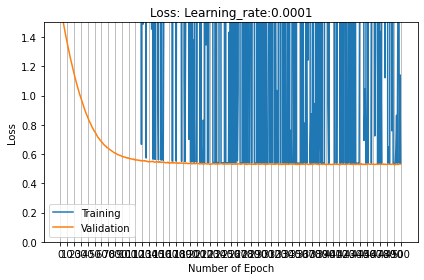

In [26]:
for lr in [1e-4]:
    print(f'=======dr:{lr}========')
    torch.cuda.empty_cache()
        
    model = Original_Model(
    num_classes=5,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    num_dense_layers=8,
    input_dim = 16,
    return_logits=True,
    conv_dropout_rate=0,
    dense_dropout_rate=0.8
    ).to(device)

    epoch = 500
    train_batch_size = 32
    val_batch_size = 128
    # lr = 0.008
    
    # lr = 0.00002
    lr = lr

    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0

    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, num_workers=8)
    test_loader = DataLoader(dataset=val_dataset, batch_size=val_batch_size, num_workers=8, shuffle=True)
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    # criterion = F.cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-8)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=8)

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    print(f'./graphs1/loss_lr_{lr}_SINGLE.png')


    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x_train, y_train in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            x_batch = x_batch.float()
            # y_batch = y_batch.view(-1)

            # y_batch = one_hot_torch(y).to(device)
            # print('batch y size before flatten:',y_batch.size())
            # y_batch = y_batch.flatten()
            # print('batch y size after flatten:',y_batch.size())
            # print(x_batch.size())
            # print(x_batch.size())
        # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
            # print(x_batch.size())
            pred = model(x_batch.float())
            # print(x_batch)

            pred = pred.float()
            # pred = pred.unsqueeze(0)
            # ic(pred)
            # ic(y_batch)
            loss_train = criterion(pred, y_batch)
            train_batch_loss.append(loss_train)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step(loss_train) 
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('test')
            for x_test, y_test in test_loader:
                x_batch = x_test.to(device)
                y_batch = y_test.to(device)
                
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())
                # pred = pred.unsqueeze(0)
                # loss_test = criterion(y_batch, pred)
                
                loss_test = criterion(pred, y_batch)
                test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
                
        if e % 100 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 

    print('==='*10)
    # lossGraph(train_epoch_loss, test_epoch_loss)
        
    
    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.set_ylim([0, 1.5])

    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    
    # testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
    testing_dataset = OneHotSeqsDataset(test_data, test_target)

    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    model.eval()  # For inference

    ic.disable()
    model.eval()
    pred_list = []
    target_list  = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test in testing_loader1:
            xtest1 = x_test.to(device).float()
            ytest1 = y_test.to(device).float()
            pred = model(xtest1)
            pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
            target_list.append(y_test.detach().cpu().numpy())
    target_list = np.array(target_list).flatten()


    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    # Example usage
    # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
    # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

    print("======================")
    print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")

# Adapted Model with cnn

In [24]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=1,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.0,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=5,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=50, # batch_size = 64
num_dense_layers=3,
return_logits=True,
conv_dropout_rate=0.0,
dense_dropout_rate=0.0
).to(device)

epoch = 350
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 0.001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

## Training

### schedular model

In [70]:
torch.cuda.empty_cache()
CUDA_LAUNCH_BLOCKING=1

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=5,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1.5,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.0,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        self.feature_extraction_layer = self._conv_layer(
            in_channels, num_filters, filter_length
        )
        
        #dynamic filter scaling from deepram
        current_num_filters = num_filters
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters, int(current_num_filters * filter_scaling_factor), 3)
            self.conv_layers.append(layer)
            current_num_filters = int(current_num_filters * filter_scaling_factor)

        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )

    def forward(self, x):
        # first pass over input
        # print(x.size())
        x = self.feature_extraction_layer(x)
        # conv layers
        for layer in self.conv_layers:
            x = layer(x)
        # global max pool 1D
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

model = Model(
num_classes=5,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=50, # batch_size = 64
num_dense_layers=3,
return_logits=True,
conv_dropout_rate=0.0,
dense_dropout_rate=0.0
).to(device)

epoch = 350
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 0.0005

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
from torch.optim.lr_scheduler import OneCycleLR

scheduler = OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=epoch)

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

In [71]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    
    for x, y in train_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = torch.unsqueeze(x_batch, 1)
        # x_batch = x_batch.permute((1,0,2))
        # y_batch = torch.unsqueeze(y_batch, 1)
        y_batch = y_batch.long()

        pred = model(x_batch.float())
        # print("Pred shape:", pred.shape)  # Should be [batch_size, num_classes]
        # print("Pred type:", pred.dtype)  # Should be torch.float32
        # print("Y_batch shape:", y_batch.shape)  # Should be [batch_size]
        # print("Y_batch type:", y_batch.dtype)  # Should be torch.int64 or torch.long

            
        ic(pred.size())
        # pred = torch.unsqueeze(pred, 1)
        
        loss_train = criterion(pred, y_batch)
        ic(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x, y in test_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            x_batch = x.to(device)
            y_batch = y.to(device)
            x_batch = torch.unsqueeze(x_batch, 1)
            
            y_batch = y_batch.long()
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            # pred = pred.unsqueeze(0)
            


            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
    test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
        # print(train_batch_loss)
        # print(test_batch_loss)
        # print(f"Training loss: {np.mean(train_batch_loss)}")
        # print(f"Validation loss: {np.mean(test_batch_loss)}")
print('==='*10)

  0%|          | 1/350 [00:01<10:53,  1.87s/it]

Epoch 1
Training loss: 1.4430946111679077
Validation loss: 1.3082995414733887


  1%|          | 2/350 [00:03<11:03,  1.91s/it]

Epoch 2
Training loss: 1.1334770917892456
Validation loss: 1.1454412937164307


  1%|          | 3/350 [00:05<10:28,  1.81s/it]

Epoch 3
Training loss: 1.0362061262130737
Validation loss: 1.033258080482483


  1%|          | 4/350 [00:07<10:25,  1.81s/it]

Epoch 4
Training loss: 0.9825137853622437
Validation loss: 1.0739014148712158


  1%|▏         | 5/350 [00:09<10:21,  1.80s/it]

Epoch 5
Training loss: 0.9601112008094788
Validation loss: 1.0079119205474854


  2%|▏         | 6/350 [00:10<10:24,  1.81s/it]

Epoch 6
Training loss: 0.9354619383811951
Validation loss: 0.993945837020874


  2%|▏         | 7/350 [00:12<10:24,  1.82s/it]

Epoch 7
Training loss: 0.9211026430130005
Validation loss: 0.958064615726471


  2%|▏         | 8/350 [00:14<10:24,  1.83s/it]

Epoch 8
Training loss: 0.9073176980018616
Validation loss: 0.942975640296936


  3%|▎         | 9/350 [00:16<10:20,  1.82s/it]

Epoch 9
Training loss: 0.9040101766586304
Validation loss: 0.923333466053009


  3%|▎         | 10/350 [00:18<10:11,  1.80s/it]

Epoch 10
Training loss: 0.8912810683250427
Validation loss: 0.9617640972137451


  3%|▎         | 11/350 [00:20<10:14,  1.81s/it]

Epoch 11
Training loss: 0.8842015266418457
Validation loss: 0.9315659403800964


  3%|▎         | 12/350 [00:21<10:11,  1.81s/it]

Epoch 12
Training loss: 0.878214955329895
Validation loss: 0.9261777400970459


  4%|▎         | 13/350 [00:23<10:15,  1.83s/it]

Epoch 13
Training loss: 0.8765972852706909
Validation loss: 0.9717938899993896


  4%|▍         | 14/350 [00:25<10:13,  1.83s/it]

Epoch 14
Training loss: 0.8700259327888489
Validation loss: 1.1409549713134766


  4%|▍         | 15/350 [00:27<10:13,  1.83s/it]

Epoch 15
Training loss: 0.8705031275749207
Validation loss: 0.9534766674041748


  5%|▍         | 16/350 [00:29<10:10,  1.83s/it]

Epoch 16
Training loss: 0.8661406636238098
Validation loss: 0.9722439050674438


  5%|▍         | 17/350 [00:31<10:19,  1.86s/it]

Epoch 17
Training loss: 0.8811691403388977
Validation loss: 1.0183714628219604


  5%|▌         | 18/350 [00:32<10:20,  1.87s/it]

Epoch 18
Training loss: 0.8776947259902954
Validation loss: 0.9660255312919617


  5%|▌         | 19/350 [00:34<10:12,  1.85s/it]

Epoch 19
Training loss: 0.8747319579124451
Validation loss: 0.896297812461853


  6%|▌         | 20/350 [00:36<10:06,  1.84s/it]

Epoch 20
Training loss: 0.8668123483657837
Validation loss: 1.0637896060943604


  6%|▌         | 21/350 [00:38<09:49,  1.79s/it]

Epoch 21
Training loss: 0.8596729636192322
Validation loss: 0.9239660501480103


  6%|▋         | 22/350 [00:40<09:53,  1.81s/it]

Epoch 22
Training loss: 0.8525912761688232
Validation loss: 0.9409375190734863


  7%|▋         | 23/350 [00:41<09:53,  1.82s/it]

Epoch 23
Training loss: 0.8598415851593018
Validation loss: 1.0213122367858887


  7%|▋         | 24/350 [00:43<09:48,  1.80s/it]

Epoch 24
Training loss: 0.874485433101654
Validation loss: 0.9732757806777954


  7%|▋         | 25/350 [00:45<09:59,  1.84s/it]

Epoch 25
Training loss: 0.8663868308067322
Validation loss: 0.9712541699409485


  7%|▋         | 26/350 [00:47<09:46,  1.81s/it]

Epoch 26
Training loss: 0.8761192560195923
Validation loss: 1.0907272100448608


  8%|▊         | 27/350 [00:49<09:42,  1.80s/it]

Epoch 27
Training loss: 0.8657383918762207
Validation loss: 0.9815130233764648


  8%|▊         | 28/350 [00:51<09:45,  1.82s/it]

Epoch 28
Training loss: 0.8612174391746521
Validation loss: 1.1631840467453003


  8%|▊         | 29/350 [00:52<09:44,  1.82s/it]

Epoch 29
Training loss: 0.8662661910057068
Validation loss: 1.2397152185440063


  9%|▊         | 30/350 [00:54<09:55,  1.86s/it]

Epoch 30
Training loss: 0.8629144430160522
Validation loss: 1.0424182415008545


  9%|▉         | 31/350 [00:56<09:59,  1.88s/it]

Epoch 31
Training loss: 0.875105082988739
Validation loss: 0.9627646207809448


  9%|▉         | 32/350 [00:58<09:54,  1.87s/it]

Epoch 32
Training loss: 0.8681108355522156
Validation loss: 1.0438599586486816


  9%|▉         | 33/350 [01:00<09:58,  1.89s/it]

Epoch 33
Training loss: 0.8602635264396667
Validation loss: 0.9432881474494934


 10%|▉         | 34/350 [01:02<10:07,  1.92s/it]

Epoch 34
Training loss: 0.850053071975708
Validation loss: 0.8863820433616638


 10%|█         | 35/350 [01:04<10:02,  1.91s/it]

Epoch 35
Training loss: 0.8533626198768616
Validation loss: 1.0279629230499268


 10%|█         | 36/350 [01:06<09:59,  1.91s/it]

Epoch 36
Training loss: 0.8452751040458679
Validation loss: 1.2090177536010742


 11%|█         | 37/350 [01:08<09:57,  1.91s/it]

Epoch 37
Training loss: 0.8472546935081482
Validation loss: 0.9544471502304077


 11%|█         | 38/350 [01:10<09:54,  1.90s/it]

Epoch 38
Training loss: 0.8328716158866882
Validation loss: 0.9414116144180298


 11%|█         | 39/350 [01:12<09:53,  1.91s/it]

Epoch 39
Training loss: 0.8264309763908386
Validation loss: 0.9573541879653931


 11%|█▏        | 40/350 [01:13<09:54,  1.92s/it]

Epoch 40
Training loss: 0.8289057016372681
Validation loss: 1.2850408554077148


 12%|█▏        | 41/350 [01:15<09:57,  1.93s/it]

Epoch 41
Training loss: 0.8319079875946045
Validation loss: 0.9191962480545044


 12%|█▏        | 42/350 [01:17<09:59,  1.95s/it]

Epoch 42
Training loss: 0.8297682404518127
Validation loss: 1.3102186918258667


 12%|█▏        | 43/350 [01:19<09:52,  1.93s/it]

Epoch 43
Training loss: 0.8417428135871887
Validation loss: 0.9906666874885559


 13%|█▎        | 44/350 [01:21<09:51,  1.93s/it]

Epoch 44
Training loss: 0.823308527469635
Validation loss: 1.3957786560058594


 13%|█▎        | 45/350 [01:23<09:50,  1.94s/it]

Epoch 45
Training loss: 0.8213470578193665
Validation loss: 1.422502040863037


 13%|█▎        | 46/350 [01:25<09:46,  1.93s/it]

Epoch 46
Training loss: 0.8222963213920593
Validation loss: 1.2256324291229248


 13%|█▎        | 47/350 [01:27<09:40,  1.92s/it]

Epoch 47
Training loss: 0.8212646245956421
Validation loss: 0.8819129467010498


 14%|█▎        | 48/350 [01:29<09:32,  1.90s/it]

Epoch 48
Training loss: 0.8019232153892517
Validation loss: 1.0443141460418701


 14%|█▍        | 49/350 [01:31<09:30,  1.90s/it]

Epoch 49
Training loss: 0.8027063608169556
Validation loss: 0.8604961633682251


 14%|█▍        | 50/350 [01:33<09:34,  1.91s/it]

Epoch 50
Training loss: 0.7919498682022095
Validation loss: 1.1901662349700928


 15%|█▍        | 51/350 [01:35<09:38,  1.93s/it]

Epoch 51
Training loss: 0.7912102937698364
Validation loss: 1.0116162300109863


 15%|█▍        | 52/350 [01:37<09:32,  1.92s/it]

Epoch 52
Training loss: 0.7833367586135864
Validation loss: 1.5719528198242188


 15%|█▌        | 53/350 [01:39<09:35,  1.94s/it]

Epoch 53
Training loss: 0.8099520206451416
Validation loss: 1.1932820081710815


 15%|█▌        | 54/350 [01:40<09:29,  1.93s/it]

Epoch 54
Training loss: 0.8077888488769531
Validation loss: 0.9053975343704224


 16%|█▌        | 55/350 [01:42<09:31,  1.94s/it]

Epoch 55
Training loss: 0.7851141691207886
Validation loss: 0.9151777029037476


 16%|█▌        | 56/350 [01:44<09:25,  1.92s/it]

Epoch 56
Training loss: 0.7823235988616943
Validation loss: 0.9920747876167297


 16%|█▋        | 57/350 [01:46<09:28,  1.94s/it]

Epoch 57
Training loss: 0.7744775414466858
Validation loss: 0.9930720329284668


 17%|█▋        | 58/350 [01:48<09:22,  1.93s/it]

Epoch 58
Training loss: 0.770066499710083
Validation loss: 1.7939459085464478


 17%|█▋        | 59/350 [01:50<09:16,  1.91s/it]

Epoch 59
Training loss: 0.7734501957893372
Validation loss: 0.8732776641845703


 17%|█▋        | 60/350 [01:52<09:19,  1.93s/it]

Epoch 60
Training loss: 0.7697691917419434
Validation loss: 0.9869590997695923


 17%|█▋        | 61/350 [01:54<09:19,  1.94s/it]

Epoch 61
Training loss: 0.7690154910087585
Validation loss: 1.3901591300964355


 18%|█▊        | 62/350 [01:56<09:15,  1.93s/it]

Epoch 62
Training loss: 0.8085112571716309
Validation loss: 1.4163976907730103


 18%|█▊        | 63/350 [01:58<09:11,  1.92s/it]

Epoch 63
Training loss: 0.7935420274734497
Validation loss: 0.913918137550354


 18%|█▊        | 64/350 [02:00<09:10,  1.92s/it]

Epoch 64
Training loss: 0.7633448243141174
Validation loss: 1.0766980648040771


 19%|█▊        | 65/350 [02:02<09:08,  1.92s/it]

Epoch 65
Training loss: 0.7695756554603577
Validation loss: 1.3294368982315063


 19%|█▉        | 66/350 [02:04<09:03,  1.91s/it]

Epoch 66
Training loss: 0.7562641501426697
Validation loss: 0.9470078945159912


 19%|█▉        | 67/350 [02:05<09:00,  1.91s/it]

Epoch 67
Training loss: 0.7485141754150391
Validation loss: 0.9309689402580261


 19%|█▉        | 68/350 [02:07<08:58,  1.91s/it]

Epoch 68
Training loss: 0.7393082976341248
Validation loss: 2.2786710262298584


 20%|█▉        | 69/350 [02:09<08:52,  1.90s/it]

Epoch 69
Training loss: 0.7263553142547607
Validation loss: 1.2113960981369019


 20%|██        | 70/350 [02:11<08:59,  1.93s/it]

Epoch 70
Training loss: 0.7389017939567566
Validation loss: 1.1920658349990845


 20%|██        | 71/350 [02:13<08:55,  1.92s/it]

Epoch 71
Training loss: 0.7243898510932922
Validation loss: 2.1173739433288574


 21%|██        | 72/350 [02:15<08:53,  1.92s/it]

Epoch 72
Training loss: 0.7138193249702454
Validation loss: 0.8753766417503357


 21%|██        | 73/350 [02:17<08:47,  1.91s/it]

Epoch 73
Training loss: 0.7169424891471863
Validation loss: 0.8332025408744812


 21%|██        | 74/350 [02:19<08:45,  1.90s/it]

Epoch 74
Training loss: 0.6968679428100586
Validation loss: 1.0786230564117432


 21%|██▏       | 75/350 [02:21<08:43,  1.90s/it]

Epoch 75
Training loss: 0.6891663074493408
Validation loss: 1.0927658081054688


 22%|██▏       | 76/350 [02:23<08:40,  1.90s/it]

Epoch 76
Training loss: 0.6940771341323853
Validation loss: 1.2369065284729004


 22%|██▏       | 77/350 [02:24<08:35,  1.89s/it]

Epoch 77
Training loss: 0.6841565370559692
Validation loss: 1.0646257400512695


 22%|██▏       | 78/350 [02:26<08:31,  1.88s/it]

Epoch 78
Training loss: 0.6831703186035156
Validation loss: 2.091174602508545


 23%|██▎       | 79/350 [02:28<08:30,  1.89s/it]

Epoch 79
Training loss: 0.6712658405303955
Validation loss: 1.0727312564849854


 23%|██▎       | 80/350 [02:30<08:34,  1.91s/it]

Epoch 80
Training loss: 0.6639834642410278
Validation loss: 1.8206465244293213


 23%|██▎       | 81/350 [02:32<08:31,  1.90s/it]

Epoch 81
Training loss: 0.658368706703186
Validation loss: 1.1001167297363281


 23%|██▎       | 82/350 [02:34<08:21,  1.87s/it]

Epoch 82
Training loss: 0.6437866687774658
Validation loss: 1.1106624603271484


 24%|██▎       | 83/350 [02:36<08:32,  1.92s/it]

Epoch 83
Training loss: 0.6486786007881165
Validation loss: 4.594993591308594


 24%|██▍       | 84/350 [02:38<08:54,  2.01s/it]

Epoch 84
Training loss: 0.6472540497779846
Validation loss: 0.9464390277862549


 24%|██▍       | 85/350 [02:40<09:06,  2.06s/it]

Epoch 85
Training loss: 0.6331559419631958
Validation loss: 0.8343818187713623


 25%|██▍       | 86/350 [02:43<09:19,  2.12s/it]

Epoch 86
Training loss: 0.6590127944946289
Validation loss: 1.250459909439087


 25%|██▍       | 87/350 [02:45<09:27,  2.16s/it]

Epoch 87
Training loss: 0.6412439942359924
Validation loss: 2.487298011779785


 25%|██▌       | 88/350 [02:47<09:31,  2.18s/it]

Epoch 88
Training loss: 0.6419866681098938
Validation loss: 1.0992469787597656


 25%|██▌       | 89/350 [02:49<09:28,  2.18s/it]

Epoch 89
Training loss: 0.6355708241462708
Validation loss: 0.9972856640815735


 26%|██▌       | 90/350 [02:51<09:29,  2.19s/it]

Epoch 90
Training loss: 0.6398224234580994
Validation loss: 1.1261957883834839


 26%|██▌       | 91/350 [02:54<09:30,  2.20s/it]

Epoch 91
Training loss: 0.6322659254074097
Validation loss: 1.3583595752716064


 26%|██▋       | 92/350 [02:56<09:25,  2.19s/it]

Epoch 92
Training loss: 0.6237865090370178
Validation loss: 0.9918954968452454


 27%|██▋       | 93/350 [02:58<09:24,  2.20s/it]

Epoch 93
Training loss: 0.621199905872345
Validation loss: 0.8436858057975769


 27%|██▋       | 94/350 [03:00<09:20,  2.19s/it]

Epoch 94
Training loss: 0.6285699605941772
Validation loss: 1.4516658782958984


 27%|██▋       | 95/350 [03:02<09:20,  2.20s/it]

Epoch 95
Training loss: 0.6072239279747009
Validation loss: 1.1033990383148193


 27%|██▋       | 96/350 [03:05<09:18,  2.20s/it]

Epoch 96
Training loss: 0.6053574681282043
Validation loss: 1.0633128881454468


 28%|██▊       | 97/350 [03:07<09:15,  2.20s/it]

Epoch 97
Training loss: 0.6327977180480957
Validation loss: 2.158141851425171


 28%|██▊       | 98/350 [03:09<09:13,  2.20s/it]

Epoch 98
Training loss: 0.6219416260719299
Validation loss: 13.325182914733887


 28%|██▊       | 99/350 [03:11<09:17,  2.22s/it]

Epoch 99
Training loss: 0.6361406445503235
Validation loss: 6.686007976531982


 29%|██▊       | 100/350 [03:13<09:08,  2.19s/it]

Epoch 100
Training loss: 0.6112866997718811
Validation loss: 1.6224510669708252


 29%|██▉       | 101/350 [03:16<09:00,  2.17s/it]

Epoch 101
Training loss: 0.6161748766899109
Validation loss: 0.826164960861206


 29%|██▉       | 102/350 [03:18<08:55,  2.16s/it]

Epoch 102
Training loss: 0.5913410186767578
Validation loss: 1.4666551351547241


 29%|██▉       | 103/350 [03:20<08:56,  2.17s/it]

Epoch 103
Training loss: 0.5962706804275513
Validation loss: 0.992310106754303


 30%|██▉       | 104/350 [03:22<08:56,  2.18s/it]

Epoch 104
Training loss: 0.5993000268936157
Validation loss: 1.3346686363220215


 30%|███       | 105/350 [03:24<08:57,  2.19s/it]

Epoch 105
Training loss: 0.6060624122619629
Validation loss: 1.3826701641082764


 30%|███       | 106/350 [03:26<08:51,  2.18s/it]

Epoch 106
Training loss: 0.5843425393104553
Validation loss: 1.1160283088684082


 31%|███       | 107/350 [03:29<08:52,  2.19s/it]

Epoch 107
Training loss: 0.5830324292182922
Validation loss: 1.0754761695861816


 31%|███       | 108/350 [03:31<08:52,  2.20s/it]

Epoch 108
Training loss: 0.5863536596298218
Validation loss: 1.1158392429351807


 31%|███       | 109/350 [03:33<08:53,  2.21s/it]

Epoch 109
Training loss: 0.5741307735443115
Validation loss: 0.8927512764930725


 31%|███▏      | 110/350 [03:35<08:52,  2.22s/it]

Epoch 110
Training loss: 0.5996140837669373
Validation loss: 0.9849840402603149


 32%|███▏      | 111/350 [03:38<08:49,  2.21s/it]

Epoch 111
Training loss: 0.5861514806747437
Validation loss: 1.7658181190490723


 32%|███▏      | 112/350 [03:40<08:46,  2.21s/it]

Epoch 112
Training loss: 0.5770342350006104
Validation loss: 22.825054168701172


 32%|███▏      | 113/350 [03:42<08:45,  2.22s/it]

Epoch 113
Training loss: 0.5693942904472351
Validation loss: 0.8420956134796143


 33%|███▎      | 114/350 [03:44<08:41,  2.21s/it]

Epoch 114
Training loss: 0.5674076676368713
Validation loss: 1.2556661367416382


 33%|███▎      | 115/350 [03:46<08:39,  2.21s/it]

Epoch 115
Training loss: 0.5701438784599304
Validation loss: 0.788823664188385


 33%|███▎      | 116/350 [03:49<08:34,  2.20s/it]

Epoch 116
Training loss: 0.5682036280632019
Validation loss: 2.4499354362487793


 33%|███▎      | 117/350 [03:51<08:39,  2.23s/it]

Epoch 117
Training loss: 0.5672643184661865
Validation loss: 1.0125354528427124


 34%|███▎      | 118/350 [03:53<08:39,  2.24s/it]

Epoch 118
Training loss: 0.5668270587921143
Validation loss: 1.3284804821014404


 34%|███▍      | 119/350 [03:55<08:29,  2.21s/it]

Epoch 119
Training loss: 0.5578437447547913
Validation loss: 15.057513236999512


 34%|███▍      | 120/350 [03:58<08:31,  2.23s/it]

Epoch 120
Training loss: 0.5801158547401428
Validation loss: 1.3317525386810303


 35%|███▍      | 121/350 [04:00<08:28,  2.22s/it]

Epoch 121
Training loss: 0.5677425861358643
Validation loss: 1.5687668323516846


 35%|███▍      | 122/350 [04:02<08:29,  2.23s/it]

Epoch 122
Training loss: 0.5582334995269775
Validation loss: 1.252425193786621


 35%|███▌      | 123/350 [04:04<08:28,  2.24s/it]

Epoch 123
Training loss: 0.5652391910552979
Validation loss: 1.1283459663391113


 35%|███▌      | 124/350 [04:07<08:28,  2.25s/it]

Epoch 124
Training loss: 0.5619687438011169
Validation loss: 0.8638118505477905


 36%|███▌      | 125/350 [04:09<08:25,  2.25s/it]

Epoch 125
Training loss: 0.5491076111793518
Validation loss: 2.17810320854187


 36%|███▌      | 126/350 [04:11<08:26,  2.26s/it]

Epoch 126
Training loss: 0.5605105757713318
Validation loss: 1.510796308517456


 36%|███▋      | 127/350 [04:13<08:25,  2.27s/it]

Epoch 127
Training loss: 0.5474081635475159
Validation loss: 0.9410878419876099


 37%|███▋      | 128/350 [04:16<08:25,  2.28s/it]

Epoch 128
Training loss: 0.5441836714744568
Validation loss: 2.322091579437256


 37%|███▋      | 129/350 [04:18<08:16,  2.25s/it]

Epoch 129
Training loss: 0.5445445775985718
Validation loss: 1.5805177688598633


 37%|███▋      | 130/350 [04:20<08:17,  2.26s/it]

Epoch 130
Training loss: 0.5384932160377502
Validation loss: 2.2379183769226074


 37%|███▋      | 131/350 [04:22<08:19,  2.28s/it]

Epoch 131
Training loss: 0.5427559614181519
Validation loss: 0.986233115196228


 38%|███▊      | 132/350 [04:25<08:18,  2.29s/it]

Epoch 132
Training loss: 0.5432159900665283
Validation loss: 1.279927134513855


 38%|███▊      | 133/350 [04:27<08:18,  2.30s/it]

Epoch 133
Training loss: 0.5432911515235901
Validation loss: 1.0481531620025635


 38%|███▊      | 134/350 [04:29<08:10,  2.27s/it]

Epoch 134
Training loss: 0.5450317859649658
Validation loss: 0.8390039205551147


 39%|███▊      | 135/350 [04:32<08:05,  2.26s/it]

Epoch 135
Training loss: 0.54329913854599
Validation loss: 2.160862922668457


 39%|███▉      | 136/350 [04:34<08:09,  2.29s/it]

Epoch 136
Training loss: 0.5468481779098511
Validation loss: 1.037660837173462


 39%|███▉      | 137/350 [04:36<08:04,  2.27s/it]

Epoch 137
Training loss: 0.5355209112167358
Validation loss: 1.4605605602264404


 39%|███▉      | 138/350 [04:38<08:00,  2.27s/it]

Epoch 138
Training loss: 0.5382494926452637
Validation loss: 1.1405208110809326


 40%|███▉      | 139/350 [04:41<07:59,  2.27s/it]

Epoch 139
Training loss: 0.5294864773750305
Validation loss: 1.3961529731750488


 40%|████      | 140/350 [04:43<07:59,  2.28s/it]

Epoch 140
Training loss: 0.5353538393974304
Validation loss: 1.1348724365234375


 40%|████      | 141/350 [04:45<07:56,  2.28s/it]

Epoch 141
Training loss: 0.5349087715148926
Validation loss: 0.7629915475845337


 41%|████      | 142/350 [04:48<07:55,  2.29s/it]

Epoch 142
Training loss: 0.5398849248886108
Validation loss: 1.2077538967132568


 41%|████      | 143/350 [04:50<07:54,  2.29s/it]

Epoch 143
Training loss: 0.5349972248077393
Validation loss: 0.9773889183998108


 41%|████      | 144/350 [04:52<07:53,  2.30s/it]

Epoch 144
Training loss: 0.5280576944351196
Validation loss: 1.1389551162719727


 41%|████▏     | 145/350 [04:54<07:50,  2.29s/it]

Epoch 145
Training loss: 0.5259816646575928
Validation loss: 1.2486419677734375


 42%|████▏     | 146/350 [04:57<07:52,  2.32s/it]

Epoch 146
Training loss: 0.5368613004684448
Validation loss: 3.9949147701263428


 42%|████▏     | 147/350 [04:59<07:49,  2.31s/it]

Epoch 147
Training loss: 0.526499330997467
Validation loss: 1.9739853143692017


 42%|████▏     | 148/350 [05:01<07:48,  2.32s/it]

Epoch 148
Training loss: 0.5158926248550415
Validation loss: 1.0437566041946411


 43%|████▎     | 149/350 [05:04<07:39,  2.28s/it]

Epoch 149
Training loss: 0.5220580101013184
Validation loss: 0.9156311750411987


 43%|████▎     | 150/350 [05:06<07:40,  2.30s/it]

Epoch 150
Training loss: 0.5218216776847839
Validation loss: 11.128435134887695


 43%|████▎     | 151/350 [05:08<07:31,  2.27s/it]

Epoch 151
Training loss: 0.5206936001777649
Validation loss: 0.9808709621429443


 43%|████▎     | 152/350 [05:10<07:25,  2.25s/it]

Epoch 152
Training loss: 0.5098057985305786
Validation loss: 0.9786199927330017


 44%|████▎     | 153/350 [05:13<07:22,  2.24s/it]

Epoch 153
Training loss: 0.5178332924842834
Validation loss: 3.7841029167175293


 44%|████▍     | 154/350 [05:15<07:14,  2.22s/it]

Epoch 154
Training loss: 0.5102788209915161
Validation loss: 1.3617229461669922


 44%|████▍     | 155/350 [05:17<07:09,  2.20s/it]

Epoch 155
Training loss: 0.5133793950080872
Validation loss: 0.966850757598877


 45%|████▍     | 156/350 [05:19<07:03,  2.18s/it]

Epoch 156
Training loss: 0.5163131356239319
Validation loss: 1.2217090129852295


 45%|████▍     | 157/350 [05:21<07:05,  2.21s/it]

Epoch 157
Training loss: 0.536413311958313
Validation loss: 1.165889024734497


 45%|████▌     | 158/350 [05:23<07:00,  2.19s/it]

Epoch 158
Training loss: 0.5180168747901917
Validation loss: 2.541382312774658


 45%|████▌     | 159/350 [05:26<06:58,  2.19s/it]

Epoch 159
Training loss: 0.5095943808555603
Validation loss: 1.0667191743850708


 46%|████▌     | 160/350 [05:28<06:58,  2.20s/it]

Epoch 160
Training loss: 0.5083248019218445
Validation loss: 1.2905936241149902


 46%|████▌     | 161/350 [05:30<06:52,  2.18s/it]

Epoch 161
Training loss: 0.5137979984283447
Validation loss: 0.9134040474891663


 46%|████▋     | 162/350 [05:32<06:48,  2.17s/it]

Epoch 162
Training loss: 0.4995557367801666
Validation loss: 1.5007295608520508


 47%|████▋     | 163/350 [05:34<06:48,  2.18s/it]

Epoch 163
Training loss: 0.4956800043582916
Validation loss: 1.2886011600494385


 47%|████▋     | 164/350 [05:37<06:44,  2.18s/it]

Epoch 164
Training loss: 0.5047110915184021
Validation loss: 1.088699221611023


 47%|████▋     | 165/350 [05:39<06:42,  2.18s/it]

Epoch 165
Training loss: 0.49694323539733887
Validation loss: 1.6321473121643066


 47%|████▋     | 166/350 [05:41<06:37,  2.16s/it]

Epoch 166
Training loss: 0.5046530365943909
Validation loss: 1.6300501823425293


 48%|████▊     | 167/350 [05:43<06:34,  2.16s/it]

Epoch 167
Training loss: 0.5083357691764832
Validation loss: 0.9633703231811523


 48%|████▊     | 168/350 [05:45<06:29,  2.14s/it]

Epoch 168
Training loss: 0.499994695186615
Validation loss: 1.9156911373138428


 48%|████▊     | 169/350 [05:47<06:26,  2.14s/it]

Epoch 169
Training loss: 0.48378628492355347
Validation loss: 1.5982705354690552


 49%|████▊     | 170/350 [05:49<06:25,  2.14s/it]

Epoch 170
Training loss: 0.4999786615371704
Validation loss: 0.926938533782959


 49%|████▉     | 171/350 [05:52<06:23,  2.14s/it]

Epoch 171
Training loss: 0.479101300239563
Validation loss: 1.1718708276748657


 49%|████▉     | 172/350 [05:54<06:21,  2.14s/it]

Epoch 172
Training loss: 0.49059587717056274
Validation loss: 1.2200117111206055


 49%|████▉     | 173/350 [05:56<06:22,  2.16s/it]

Epoch 173
Training loss: 0.49624088406562805
Validation loss: 0.804088830947876


 50%|████▉     | 174/350 [05:58<06:15,  2.13s/it]

Epoch 174
Training loss: 0.488599956035614
Validation loss: 1.446449637413025


 50%|█████     | 175/350 [06:00<06:13,  2.14s/it]

Epoch 175
Training loss: 0.49151039123535156
Validation loss: 1.1795477867126465


 50%|█████     | 176/350 [06:02<06:12,  2.14s/it]

Epoch 176
Training loss: 0.5018152594566345
Validation loss: 1.1026599407196045


 51%|█████     | 177/350 [06:04<06:08,  2.13s/it]

Epoch 177
Training loss: 0.48989152908325195
Validation loss: 0.8117914795875549


 51%|█████     | 178/350 [06:06<06:03,  2.11s/it]

Epoch 178
Training loss: 0.48315468430519104
Validation loss: 1.0865099430084229


 51%|█████     | 179/350 [06:09<06:01,  2.11s/it]

Epoch 179
Training loss: 0.4856226146221161
Validation loss: 2.7348971366882324


 51%|█████▏    | 180/350 [06:11<06:02,  2.14s/it]

Epoch 180
Training loss: 0.4793541133403778
Validation loss: 0.9328145384788513


 52%|█████▏    | 181/350 [06:13<05:59,  2.13s/it]

Epoch 181
Training loss: 0.49150264263153076
Validation loss: 2.3708248138427734


 52%|█████▏    | 182/350 [06:15<06:01,  2.15s/it]

Epoch 182
Training loss: 0.49403706192970276
Validation loss: 2.439284324645996


 52%|█████▏    | 183/350 [06:17<05:59,  2.15s/it]

Epoch 183
Training loss: 0.48352184891700745
Validation loss: 1.7477514743804932


 53%|█████▎    | 184/350 [06:19<06:02,  2.18s/it]

Epoch 184
Training loss: 0.4804684817790985
Validation loss: 1.5470860004425049


 53%|█████▎    | 185/350 [06:22<06:01,  2.19s/it]

Epoch 185
Training loss: 0.4849517047405243
Validation loss: 1.1605167388916016


 53%|█████▎    | 186/350 [06:24<06:02,  2.21s/it]

Epoch 186
Training loss: 0.46994948387145996
Validation loss: 0.9808222055435181


 53%|█████▎    | 187/350 [06:26<05:59,  2.20s/it]

Epoch 187
Training loss: 0.47728466987609863
Validation loss: 1.2774651050567627


 54%|█████▎    | 188/350 [06:28<05:52,  2.18s/it]

Epoch 188
Training loss: 0.4715135097503662
Validation loss: 1.1033443212509155


 54%|█████▍    | 189/350 [06:30<05:48,  2.16s/it]

Epoch 189
Training loss: 0.47919848561286926
Validation loss: 1.4125440120697021


 54%|█████▍    | 190/350 [06:33<05:45,  2.16s/it]

Epoch 190
Training loss: 0.4710697531700134
Validation loss: 1.1236804723739624


 55%|█████▍    | 191/350 [06:35<05:41,  2.15s/it]

Epoch 191
Training loss: 0.4746030867099762
Validation loss: 1.0406856536865234


 55%|█████▍    | 192/350 [06:37<05:40,  2.15s/it]

Epoch 192
Training loss: 0.47203680872917175
Validation loss: 1.1190581321716309


 55%|█████▌    | 193/350 [06:39<05:37,  2.15s/it]

Epoch 193
Training loss: 0.46451622247695923
Validation loss: 1.2985104322433472


 55%|█████▌    | 194/350 [06:41<05:34,  2.14s/it]

Epoch 194
Training loss: 0.4567105770111084
Validation loss: 0.8364273309707642


 56%|█████▌    | 195/350 [06:43<05:33,  2.15s/it]

Epoch 195
Training loss: 0.46063148975372314
Validation loss: 1.3384926319122314


 56%|█████▌    | 196/350 [06:45<05:30,  2.14s/it]

Epoch 196
Training loss: 0.4723895192146301
Validation loss: 1.8493001461029053


 56%|█████▋    | 197/350 [06:47<05:26,  2.13s/it]

Epoch 197
Training loss: 0.4614121913909912
Validation loss: 1.036651611328125


 57%|█████▋    | 198/350 [06:50<05:25,  2.14s/it]

Epoch 198
Training loss: 0.46024200320243835
Validation loss: 0.8260104060173035


 57%|█████▋    | 199/350 [06:52<05:22,  2.14s/it]

Epoch 199
Training loss: 0.45846813917160034
Validation loss: 0.9377106428146362


 57%|█████▋    | 200/350 [06:54<05:23,  2.16s/it]

Epoch 200
Training loss: 0.4640972912311554
Validation loss: 1.1925805807113647


 57%|█████▋    | 201/350 [06:56<05:23,  2.17s/it]

Epoch 201
Training loss: 0.45490947365760803
Validation loss: 1.1036196947097778


 58%|█████▊    | 202/350 [06:58<05:19,  2.16s/it]

Epoch 202
Training loss: 0.45483192801475525
Validation loss: 3.2092843055725098


 58%|█████▊    | 203/350 [07:00<05:17,  2.16s/it]

Epoch 203
Training loss: 0.4591226875782013
Validation loss: 3.549802780151367


 58%|█████▊    | 204/350 [07:03<05:14,  2.15s/it]

Epoch 204
Training loss: 0.4471522271633148
Validation loss: 1.4603869915008545


 59%|█████▊    | 205/350 [07:05<05:11,  2.15s/it]

Epoch 205
Training loss: 0.4433230757713318
Validation loss: 1.4694702625274658


 59%|█████▉    | 206/350 [07:07<05:10,  2.16s/it]

Epoch 206
Training loss: 0.44818761944770813
Validation loss: 1.306907057762146


 59%|█████▉    | 207/350 [07:09<05:10,  2.17s/it]

Epoch 207
Training loss: 0.4692215621471405
Validation loss: 2.1578078269958496


 59%|█████▉    | 208/350 [07:11<05:06,  2.16s/it]

Epoch 208
Training loss: 0.44404473900794983
Validation loss: 0.8731119632720947


 60%|█████▉    | 209/350 [07:13<05:07,  2.18s/it]

Epoch 209
Training loss: 0.44436824321746826
Validation loss: 1.3142573833465576


 60%|██████    | 210/350 [07:16<05:04,  2.18s/it]

Epoch 210
Training loss: 0.45508918166160583
Validation loss: 0.8785761594772339


 60%|██████    | 211/350 [07:18<05:04,  2.19s/it]

Epoch 211
Training loss: 0.4496135413646698
Validation loss: 2.1864514350891113


 61%|██████    | 212/350 [07:20<05:00,  2.18s/it]

Epoch 212
Training loss: 0.43677833676338196
Validation loss: 1.1243793964385986


 61%|██████    | 213/350 [07:22<04:57,  2.17s/it]

Epoch 213
Training loss: 0.4355616271495819
Validation loss: 0.8452097177505493


 61%|██████    | 214/350 [07:24<04:53,  2.16s/it]

Epoch 214
Training loss: 0.4338129162788391
Validation loss: 1.451910138130188


 61%|██████▏   | 215/350 [07:27<04:53,  2.18s/it]

Epoch 215
Training loss: 0.43053382635116577
Validation loss: 1.1163232326507568


 62%|██████▏   | 216/350 [07:29<04:53,  2.19s/it]

Epoch 216
Training loss: 0.44245269894599915
Validation loss: 0.8714113831520081


 62%|██████▏   | 217/350 [07:31<04:51,  2.19s/it]

Epoch 217
Training loss: 0.4324050545692444
Validation loss: 0.9866596460342407


 62%|██████▏   | 218/350 [07:33<04:42,  2.14s/it]

Epoch 218
Training loss: 0.42904162406921387
Validation loss: 1.1601614952087402


 63%|██████▎   | 219/350 [07:35<04:44,  2.17s/it]

Epoch 219
Training loss: 0.43139058351516724
Validation loss: 0.7886964082717896


 63%|██████▎   | 220/350 [07:37<04:44,  2.18s/it]

Epoch 220
Training loss: 0.4258931577205658
Validation loss: 0.9213240146636963


 63%|██████▎   | 221/350 [07:40<04:42,  2.19s/it]

Epoch 221
Training loss: 0.4289376139640808
Validation loss: 0.8023897409439087


 63%|██████▎   | 222/350 [07:42<04:42,  2.21s/it]

Epoch 222
Training loss: 0.42900708317756653
Validation loss: 0.9789445400238037


 64%|██████▎   | 223/350 [07:44<04:39,  2.20s/it]

Epoch 223
Training loss: 0.418310284614563
Validation loss: 1.7305926084518433


 64%|██████▍   | 224/350 [07:46<04:38,  2.21s/it]

Epoch 224
Training loss: 0.4229111075401306
Validation loss: 1.2761595249176025


 64%|██████▍   | 225/350 [07:48<04:33,  2.19s/it]

Epoch 225
Training loss: 0.4231796860694885
Validation loss: 0.9447338581085205


 65%|██████▍   | 226/350 [07:51<04:32,  2.20s/it]

Epoch 226
Training loss: 0.4173910915851593
Validation loss: 0.8070375919342041


 65%|██████▍   | 227/350 [07:53<04:31,  2.21s/it]

Epoch 227
Training loss: 0.4167953133583069
Validation loss: 0.9755244255065918


 65%|██████▌   | 228/350 [07:55<04:29,  2.21s/it]

Epoch 228
Training loss: 0.41756364703178406
Validation loss: 1.8695523738861084


 65%|██████▌   | 229/350 [07:57<04:27,  2.21s/it]

Epoch 229
Training loss: 0.4079359769821167
Validation loss: 1.4596459865570068


 66%|██████▌   | 230/350 [07:59<04:24,  2.21s/it]

Epoch 230
Training loss: 0.4072575271129608
Validation loss: 0.9470568895339966


 66%|██████▌   | 231/350 [08:02<04:22,  2.20s/it]

Epoch 231
Training loss: 0.4085283577442169
Validation loss: 1.3412015438079834


 66%|██████▋   | 232/350 [08:04<04:20,  2.21s/it]

Epoch 232
Training loss: 0.40835702419281006
Validation loss: 1.099759817123413


 67%|██████▋   | 233/350 [08:06<04:20,  2.22s/it]

Epoch 233
Training loss: 0.41064995527267456
Validation loss: 1.1751563549041748


 67%|██████▋   | 234/350 [08:08<04:18,  2.23s/it]

Epoch 234
Training loss: 0.4112566113471985
Validation loss: 1.3633503913879395


 67%|██████▋   | 235/350 [08:11<04:15,  2.22s/it]

Epoch 235
Training loss: 0.39818307757377625
Validation loss: 1.2043194770812988


 67%|██████▋   | 236/350 [08:13<04:13,  2.23s/it]

Epoch 236
Training loss: 0.4074399173259735
Validation loss: 0.9579423666000366


 68%|██████▊   | 237/350 [08:15<04:08,  2.20s/it]

Epoch 237
Training loss: 0.40802323818206787
Validation loss: 1.1834368705749512


 68%|██████▊   | 238/350 [08:17<04:05,  2.20s/it]

Epoch 238
Training loss: 0.40644124150276184
Validation loss: 1.1007015705108643


 68%|██████▊   | 239/350 [08:19<04:03,  2.20s/it]

Epoch 239
Training loss: 0.39198219776153564
Validation loss: 1.0206263065338135


 69%|██████▊   | 240/350 [08:22<04:01,  2.20s/it]

Epoch 240
Training loss: 0.396575927734375
Validation loss: 1.9187610149383545


 69%|██████▉   | 241/350 [08:24<03:58,  2.18s/it]

Epoch 241
Training loss: 0.4107581079006195
Validation loss: 1.312340259552002


 69%|██████▉   | 242/350 [08:26<03:56,  2.19s/it]

Epoch 242
Training loss: 0.38579657673835754
Validation loss: 0.7989570498466492


 69%|██████▉   | 243/350 [08:28<03:53,  2.18s/it]

Epoch 243
Training loss: 0.3929361402988434
Validation loss: 1.0981590747833252


 70%|██████▉   | 244/350 [08:30<03:51,  2.18s/it]

Epoch 244
Training loss: 0.3856953978538513
Validation loss: 1.0553524494171143


 70%|███████   | 245/350 [08:32<03:48,  2.18s/it]

Epoch 245
Training loss: 0.3923758566379547
Validation loss: 0.7813041806221008


 70%|███████   | 246/350 [08:35<03:46,  2.18s/it]

Epoch 246
Training loss: 0.3906092941761017
Validation loss: 1.2072978019714355


 71%|███████   | 247/350 [08:37<03:45,  2.19s/it]

Epoch 247
Training loss: 0.3786779046058655
Validation loss: 0.8917340040206909


 71%|███████   | 248/350 [08:39<03:44,  2.20s/it]

Epoch 248
Training loss: 0.3776167631149292
Validation loss: 1.2328951358795166


 71%|███████   | 249/350 [08:41<03:43,  2.21s/it]

Epoch 249
Training loss: 0.3745485246181488
Validation loss: 1.1695184707641602


 71%|███████▏  | 250/350 [08:44<03:41,  2.21s/it]

Epoch 250
Training loss: 0.3771795332431793
Validation loss: 1.4538944959640503


 72%|███████▏  | 251/350 [08:46<03:39,  2.22s/it]

Epoch 251
Training loss: 0.3764254152774811
Validation loss: 1.1811491250991821


 72%|███████▏  | 252/350 [08:48<03:38,  2.23s/it]

Epoch 252
Training loss: 0.37901949882507324
Validation loss: 1.518054723739624


 72%|███████▏  | 253/350 [08:50<03:35,  2.22s/it]

Epoch 253
Training loss: 0.37493234872817993
Validation loss: 1.333083152770996


 73%|███████▎  | 254/350 [08:52<03:34,  2.23s/it]

Epoch 254
Training loss: 0.37134048342704773
Validation loss: 0.7715935111045837


 73%|███████▎  | 255/350 [08:55<03:32,  2.24s/it]

Epoch 255
Training loss: 0.37294846773147583
Validation loss: 1.0287907123565674


 73%|███████▎  | 256/350 [08:57<03:26,  2.20s/it]

Epoch 256
Training loss: 0.3722725212574005
Validation loss: 0.7860739231109619


 73%|███████▎  | 257/350 [08:59<03:21,  2.17s/it]

Epoch 257
Training loss: 0.37731310725212097
Validation loss: 0.8296651244163513


 74%|███████▎  | 258/350 [09:01<03:21,  2.19s/it]

Epoch 258
Training loss: 0.360269695520401
Validation loss: 0.8034560084342957


 74%|███████▍  | 259/350 [09:03<03:19,  2.19s/it]

Epoch 259
Training loss: 0.3681104779243469
Validation loss: 0.8671143054962158


 74%|███████▍  | 260/350 [09:06<03:18,  2.21s/it]

Epoch 260
Training loss: 0.36699867248535156
Validation loss: 0.8560155630111694


 75%|███████▍  | 261/350 [09:08<03:15,  2.20s/it]

Epoch 261
Training loss: 0.36065709590911865
Validation loss: 0.8709121346473694


 75%|███████▍  | 262/350 [09:10<03:13,  2.20s/it]

Epoch 262
Training loss: 0.3554163873195648
Validation loss: 0.8291561603546143


 75%|███████▌  | 263/350 [09:12<03:12,  2.22s/it]

Epoch 263
Training loss: 0.3528868854045868
Validation loss: 1.082334280014038


 75%|███████▌  | 264/350 [09:14<03:09,  2.21s/it]

Epoch 264
Training loss: 0.35979267954826355
Validation loss: 0.7694464921951294


 76%|███████▌  | 265/350 [09:17<03:07,  2.21s/it]

Epoch 265
Training loss: 0.35392481088638306
Validation loss: 1.1610076427459717


 76%|███████▌  | 266/350 [09:19<03:05,  2.20s/it]

Epoch 266
Training loss: 0.3515737056732178
Validation loss: 0.954830527305603


 76%|███████▋  | 267/350 [09:21<03:02,  2.20s/it]

Epoch 267
Training loss: 0.35801753401756287
Validation loss: 0.7986840009689331


 77%|███████▋  | 268/350 [09:23<03:00,  2.20s/it]

Epoch 268
Training loss: 0.35293877124786377
Validation loss: 0.7555726766586304


 77%|███████▋  | 269/350 [09:25<02:58,  2.21s/it]

Epoch 269
Training loss: 0.3479463458061218
Validation loss: 1.0327959060668945


 77%|███████▋  | 270/350 [09:28<02:57,  2.22s/it]

Epoch 270
Training loss: 0.3458750545978546
Validation loss: 0.8705863952636719


 77%|███████▋  | 271/350 [09:30<02:55,  2.22s/it]

Epoch 271
Training loss: 0.34592440724372864
Validation loss: 0.7981389164924622


 78%|███████▊  | 272/350 [09:32<02:53,  2.22s/it]

Epoch 272
Training loss: 0.35121485590934753
Validation loss: 0.8779484629631042


 78%|███████▊  | 273/350 [09:34<02:50,  2.21s/it]

Epoch 273
Training loss: 0.34609851241111755
Validation loss: 0.8053946495056152


 78%|███████▊  | 274/350 [09:37<02:47,  2.21s/it]

Epoch 274
Training loss: 0.3428044021129608
Validation loss: 0.7741038799285889


 79%|███████▊  | 275/350 [09:39<02:45,  2.21s/it]

Epoch 275
Training loss: 0.3332248628139496
Validation loss: 0.8025507926940918


 79%|███████▉  | 276/350 [09:41<02:45,  2.24s/it]

Epoch 276
Training loss: 0.335955947637558
Validation loss: 0.884507954120636


 79%|███████▉  | 277/350 [09:43<02:43,  2.24s/it]

Epoch 277
Training loss: 0.3375592827796936
Validation loss: 0.790460467338562


 79%|███████▉  | 278/350 [09:45<02:40,  2.23s/it]

Epoch 278
Training loss: 0.33693745732307434
Validation loss: 0.8763185739517212


 80%|███████▉  | 279/350 [09:48<02:38,  2.23s/it]

Epoch 279
Training loss: 0.3346923887729645
Validation loss: 0.8102977275848389


 80%|████████  | 280/350 [09:50<02:35,  2.22s/it]

Epoch 280
Training loss: 0.3337257206439972
Validation loss: 0.7414493560791016


 80%|████████  | 281/350 [09:52<02:33,  2.23s/it]

Epoch 281
Training loss: 0.33473408222198486
Validation loss: 0.7737666368484497


 81%|████████  | 282/350 [09:54<02:31,  2.23s/it]

Epoch 282
Training loss: 0.3370436429977417
Validation loss: 0.8927890062332153


 81%|████████  | 283/350 [09:57<02:28,  2.22s/it]

Epoch 283
Training loss: 0.3243280351161957
Validation loss: 0.9103200435638428


 81%|████████  | 284/350 [09:59<02:26,  2.22s/it]

Epoch 284
Training loss: 0.3162338137626648
Validation loss: 0.7549976110458374


 81%|████████▏ | 285/350 [10:01<02:24,  2.22s/it]

Epoch 285
Training loss: 0.3281119167804718
Validation loss: 1.0191905498504639


 82%|████████▏ | 286/350 [10:03<02:22,  2.22s/it]

Epoch 286
Training loss: 0.3315432071685791
Validation loss: 0.7736202478408813


 82%|████████▏ | 287/350 [10:05<02:19,  2.22s/it]

Epoch 287
Training loss: 0.31742438673973083
Validation loss: 0.8473352193832397


 82%|████████▏ | 288/350 [10:08<02:17,  2.22s/it]

Epoch 288
Training loss: 0.3183186948299408
Validation loss: 0.9110226631164551


 83%|████████▎ | 289/350 [10:10<02:15,  2.22s/it]

Epoch 289
Training loss: 0.3169736862182617
Validation loss: 0.8416903018951416


 83%|████████▎ | 290/350 [10:12<02:12,  2.22s/it]

Epoch 290
Training loss: 0.32454609870910645
Validation loss: 0.8015977740287781


 83%|████████▎ | 291/350 [10:14<02:11,  2.24s/it]

Epoch 291
Training loss: 0.3145495355129242
Validation loss: 1.2825677394866943


 83%|████████▎ | 292/350 [10:17<02:09,  2.24s/it]

Epoch 292
Training loss: 0.3121681809425354
Validation loss: 0.7866108417510986


 84%|████████▎ | 293/350 [10:19<02:07,  2.23s/it]

Epoch 293
Training loss: 0.3179367780685425
Validation loss: 0.961016058921814


 84%|████████▍ | 294/350 [10:21<02:04,  2.22s/it]

Epoch 294
Training loss: 0.30744701623916626
Validation loss: 0.8348881006240845


 84%|████████▍ | 295/350 [10:23<01:59,  2.17s/it]

Epoch 295
Training loss: 0.3120075762271881
Validation loss: 0.9039918780326843


 85%|████████▍ | 296/350 [10:25<01:57,  2.18s/it]

Epoch 296
Training loss: 0.3076472580432892
Validation loss: 1.1269514560699463


 85%|████████▍ | 297/350 [10:28<01:57,  2.22s/it]

Epoch 297
Training loss: 0.30655142664909363
Validation loss: 0.8105711936950684


 85%|████████▌ | 298/350 [10:30<01:55,  2.22s/it]

Epoch 298
Training loss: 0.3053479790687561
Validation loss: 1.0240633487701416


 85%|████████▌ | 299/350 [10:32<01:52,  2.21s/it]

Epoch 299
Training loss: 0.31287115812301636
Validation loss: 1.4941449165344238


 86%|████████▌ | 300/350 [10:34<01:52,  2.25s/it]

Epoch 300
Training loss: 0.30697357654571533
Validation loss: 0.8724502921104431


 86%|████████▌ | 301/350 [10:37<01:50,  2.26s/it]

Epoch 301
Training loss: 0.30553969740867615
Validation loss: 0.77721107006073


 86%|████████▋ | 302/350 [10:39<01:48,  2.25s/it]

Epoch 302
Training loss: 0.3129068613052368
Validation loss: 1.2956622838974


 87%|████████▋ | 303/350 [10:41<01:45,  2.24s/it]

Epoch 303
Training loss: 0.3038097023963928
Validation loss: 0.7806349396705627


 87%|████████▋ | 304/350 [10:43<01:42,  2.23s/it]

Epoch 304
Training loss: 0.3020345866680145
Validation loss: 0.7664921879768372


 87%|████████▋ | 305/350 [10:46<01:42,  2.27s/it]

Epoch 305
Training loss: 0.3026833236217499
Validation loss: 0.8729028701782227


 87%|████████▋ | 306/350 [10:48<01:38,  2.24s/it]

Epoch 306
Training loss: 0.3001192808151245
Validation loss: 0.9377756118774414


 88%|████████▊ | 307/350 [10:50<01:36,  2.25s/it]

Epoch 307
Training loss: 0.31007933616638184
Validation loss: 0.9484140872955322


 88%|████████▊ | 308/350 [10:52<01:33,  2.23s/it]

Epoch 308
Training loss: 0.2934855818748474
Validation loss: 0.8559061288833618


 88%|████████▊ | 309/350 [10:54<01:31,  2.23s/it]

Epoch 309
Training loss: 0.29640302062034607
Validation loss: 0.7725569605827332


 89%|████████▊ | 310/350 [10:57<01:28,  2.22s/it]

Epoch 310
Training loss: 0.29592177271842957
Validation loss: 0.8841797709465027


 89%|████████▉ | 311/350 [10:59<01:26,  2.21s/it]

Epoch 311
Training loss: 0.29677534103393555
Validation loss: 1.1246678829193115


 89%|████████▉ | 312/350 [11:01<01:24,  2.21s/it]

Epoch 312
Training loss: 0.2990594804286957
Validation loss: 0.7738964557647705


 89%|████████▉ | 313/350 [11:03<01:22,  2.22s/it]

Epoch 313
Training loss: 0.29380252957344055
Validation loss: 0.8196679949760437


 90%|████████▉ | 314/350 [11:05<01:18,  2.19s/it]

Epoch 314
Training loss: 0.29143133759498596
Validation loss: 0.8571919202804565


 90%|█████████ | 315/350 [11:08<01:15,  2.15s/it]

Epoch 315
Training loss: 0.28590723872184753
Validation loss: 0.9977603554725647


 90%|█████████ | 316/350 [11:10<01:13,  2.15s/it]

Epoch 316
Training loss: 0.2897804081439972
Validation loss: 0.7841377854347229


 91%|█████████ | 317/350 [11:12<01:11,  2.18s/it]

Epoch 317
Training loss: 0.29258912801742554
Validation loss: 0.7848320603370667


 91%|█████████ | 318/350 [11:14<01:10,  2.20s/it]

Epoch 318
Training loss: 0.29286274313926697
Validation loss: 1.2568570375442505


 91%|█████████ | 319/350 [11:16<01:08,  2.20s/it]

Epoch 319
Training loss: 0.2883346378803253
Validation loss: 0.8166006803512573


 91%|█████████▏| 320/350 [11:19<01:06,  2.20s/it]

Epoch 320
Training loss: 0.2916226387023926
Validation loss: 0.7652702927589417


 92%|█████████▏| 321/350 [11:21<01:04,  2.22s/it]

Epoch 321
Training loss: 0.28665152192115784
Validation loss: 0.8042904138565063


 92%|█████████▏| 322/350 [11:23<01:02,  2.23s/it]

Epoch 322
Training loss: 0.2907101809978485
Validation loss: 0.7886263132095337


 92%|█████████▏| 323/350 [11:25<00:59,  2.21s/it]

Epoch 323
Training loss: 0.28615719079971313
Validation loss: 0.8175680637359619


 93%|█████████▎| 324/350 [11:27<00:57,  2.21s/it]

Epoch 324
Training loss: 0.2931893467903137
Validation loss: 0.8270100951194763


 93%|█████████▎| 325/350 [11:30<00:54,  2.20s/it]

Epoch 325
Training loss: 0.2867192327976227
Validation loss: 0.9484796524047852


 93%|█████████▎| 326/350 [11:32<00:52,  2.20s/it]

Epoch 326
Training loss: 0.2827889323234558
Validation loss: 0.8033689260482788


 93%|█████████▎| 327/350 [11:34<00:50,  2.21s/it]

Epoch 327
Training loss: 0.28278854489326477
Validation loss: 0.7816803455352783


 94%|█████████▎| 328/350 [11:36<00:48,  2.22s/it]

Epoch 328
Training loss: 0.283509761095047
Validation loss: 1.4316606521606445


 94%|█████████▍| 329/350 [11:39<00:46,  2.22s/it]

Epoch 329
Training loss: 0.28965213894844055
Validation loss: 0.7904938459396362


 94%|█████████▍| 330/350 [11:41<00:44,  2.22s/it]

Epoch 330
Training loss: 0.2866460382938385
Validation loss: 1.4010103940963745


 95%|█████████▍| 331/350 [11:43<00:42,  2.23s/it]

Epoch 331
Training loss: 0.2911489009857178
Validation loss: 0.9605433344841003


 95%|█████████▍| 332/350 [11:45<00:40,  2.25s/it]

Epoch 332
Training loss: 0.28490760922431946
Validation loss: 0.9394352436065674


 95%|█████████▌| 333/350 [11:48<00:38,  2.26s/it]

Epoch 333
Training loss: 0.2826535701751709
Validation loss: 0.7836165428161621


 95%|█████████▌| 334/350 [11:50<00:36,  2.26s/it]

Epoch 334
Training loss: 0.27954915165901184
Validation loss: 1.4052594900131226


 96%|█████████▌| 335/350 [11:52<00:33,  2.26s/it]

Epoch 335
Training loss: 0.27315449714660645
Validation loss: 1.1227524280548096


 96%|█████████▌| 336/350 [11:54<00:31,  2.24s/it]

Epoch 336
Training loss: 0.27635911107063293
Validation loss: 0.8076967000961304


 96%|█████████▋| 337/350 [11:57<00:29,  2.24s/it]

Epoch 337
Training loss: 0.28208839893341064
Validation loss: 0.7879782915115356


 97%|█████████▋| 338/350 [11:59<00:26,  2.23s/it]

Epoch 338
Training loss: 0.2860528826713562
Validation loss: 0.8347783088684082


 97%|█████████▋| 339/350 [12:01<00:24,  2.23s/it]

Epoch 339
Training loss: 0.2873457074165344
Validation loss: 0.8002312779426575


 97%|█████████▋| 340/350 [12:03<00:22,  2.21s/it]

Epoch 340
Training loss: 0.28159213066101074
Validation loss: 0.8154022693634033


 97%|█████████▋| 341/350 [12:05<00:19,  2.21s/it]

Epoch 341
Training loss: 0.28012245893478394
Validation loss: 0.9107990264892578


 98%|█████████▊| 342/350 [12:08<00:17,  2.21s/it]

Epoch 342
Training loss: 0.2766942083835602
Validation loss: 0.8088269233703613


 98%|█████████▊| 343/350 [12:10<00:15,  2.22s/it]

Epoch 343
Training loss: 0.28577935695648193
Validation loss: 0.8286027312278748


 98%|█████████▊| 344/350 [12:12<00:13,  2.24s/it]

Epoch 344
Training loss: 0.2813469469547272
Validation loss: 1.0434528589248657


 99%|█████████▊| 345/350 [12:14<00:11,  2.26s/it]

Epoch 345
Training loss: 0.2770339250564575
Validation loss: 0.8556265234947205


 99%|█████████▉| 346/350 [12:17<00:09,  2.27s/it]

Epoch 346
Training loss: 0.2777070105075836
Validation loss: 0.8220298886299133


 99%|█████████▉| 347/350 [12:19<00:06,  2.25s/it]

Epoch 347
Training loss: 0.2834920883178711
Validation loss: 0.8101387023925781


 99%|█████████▉| 348/350 [12:21<00:04,  2.25s/it]

Epoch 348
Training loss: 0.2787463068962097
Validation loss: 1.2574257850646973


100%|█████████▉| 349/350 [12:23<00:02,  2.23s/it]

Epoch 349
Training loss: 0.2820088863372803
Validation loss: 0.7884849309921265


100%|██████████| 350/350 [12:26<00:00,  2.13s/it]

Epoch 350
Training loss: 0.2868767976760864
Validation loss: 1.2468020915985107


test_loss_min: 0.74144936 test_loss_min_epoch: 279
train_loss_min: 0.2731545 train_loss_min_epoch: 334


/tmp/ipykernel_23138/1013243879.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


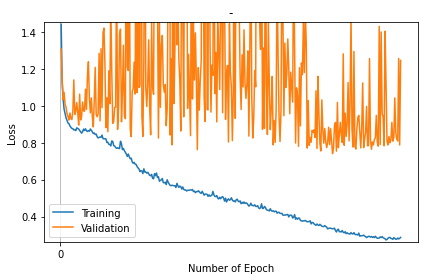

In [72]:
lossGraph(train_epoch_loss, test_epoch_loss)

In [51]:
def lossGraph(train_epoch_loss, test_epoch_loss, appendix='-'):
    fig, ax = plt.subplots(facecolor = 'white') 
    x = np.arange(1, len(train_epoch_loss)+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')   
    ax.plot(x, test_epoch_loss,label='Validation')  
    ax.legend() 
    ax.set_xlabel("Number of Epoch")    
    ax.set_ylabel("Loss")   
    ax.set_xticks(np.arange(0, +1, 10))    
    ax.set_title(f'{appendix}')
    ax.set_ylim(min(train_epoch_loss) - 0.01, max(train_epoch_loss) + 0.01)
    # ax_2 = ax.twinx() 
    # ax_2.plot(history["lr"], "k--", lw=1) 
    # ax_2.set_yscale("log")    
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0    ])
    ax.grid(axis="x")   
    fig.tight_layout()
    fig.show()  
    print('test_loss_min:', min(test_epoch_loss), 'test_loss_min_epoch:', test_epoch_loss.index(min(test_epoch_loss)))
    print('train_loss_min:', min(train_epoch_loss), 'train_loss_min_epoch:', train_epoch_loss.index(min(train_epoch_loss)))

test_loss_min: 0.7121281 test_loss_min_epoch: 92
train_loss_min: 0.05916992 train_loss_min_epoch: 344


/tmp/ipykernel_23138/1013243879.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


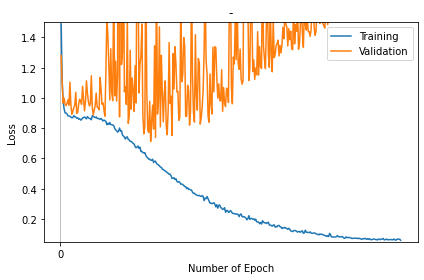

In [50]:
lossGraph(train_epoch_loss, test_epoch_loss)

In [ ]:
train_epoch_loss
test_epoch_loss

## Parameter search

In [26]:
for dr in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f'=======dr:{dr}========')
    torch.cuda.empty_cache()

    model = Model(
    num_classes=5,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=50, # batch_size = 64
    num_dense_layers=3,
    return_logits=True,
    conv_dropout_rate=0.0,
    dense_dropout_rate=dr
    ).to(device)
    

    epoch = 250
    batch_size = 128
    # lr = 0.0085
    # lr = 0.00002
    # lr = 0.001
    lr = 0.0005

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    from torch.optim.lr_scheduler import OneCycleLR

    scheduler = OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=epoch)

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    
    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        for x, y in train_loader:
            x_batch = torch.squeeze(x, 0).to(device)
            y_batch = y.to(device)
            x_batch = torch.unsqueeze(x_batch, 1)
            # x_batch = x_batch.permute((1,0,2))
            # y_batch = torch.unsqueeze(y_batch, 1)
            y_batch = y_batch.long()

            pred = model(x_batch.float())
            # print("Pred shape:", pred.shape)  # Should be [batch_size, num_classes]
            # print("Pred type:", pred.dtype)  # Should be torch.float32
            # print("Y_batch shape:", y_batch.shape)  # Should be [batch_size]
            # print("Y_batch type:", y_batch.dtype)  # Should be torch.int64 or torch.long

                
            ic(pred.size())
            # pred = torch.unsqueeze(pred, 1)
            
            loss_train = criterion(pred, y_batch)
            ic(loss_train)
            train_batch_loss.append(loss_train)
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()
            # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

            train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x, y in test_loader:
                x_batch = torch.squeeze(x, 0).to(device)
                x_batch = x.to(device)
                y_batch = y.to(device)
                x_batch = torch.unsqueeze(x_batch, 1)
                
                y_batch = y_batch.long()
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())
                # pred = pred.unsqueeze(0)
                


                loss_test = criterion(pred,y_batch)
                test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

        if e % 100 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 

            # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
            # print(train_batch_loss)
            # print(test_batch_loss)
            # print(f"Training loss: {np.mean(train_batch_loss)}")
            # print(f"Validation loss: {np.mean(test_batch_loss)}")
    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/model_lr0.00002_2conv_2dense_128neuron_60epoch_reduceonplateau.pt')
    print('train_batch_loss')
    print(train_batch_loss)
    print('test_epoch_loss')
    print(test_epoch_loss)
    
    # fig, ax = plt.subplots()
    # x = np.arange(1, len(train_epoch_loss)+1, 1)
    # ax.plot(x, train_epoch_loss,label='Training')
    # ax.plot(x, test_epoch_loss,label='Validation')
    # ax.legend()
    # ax.set_xlabel("Number of Epoch")
    # ax.set_ylabel("Loss")
    # ax.set_xticks(np.arange(0, epoch+1, 10))
    # ax.set_title(f'Loss: Learning_rate:{lr}')
    # # ax_2 = ax.twinx()
    # # ax_2.plot(history["lr"], "k--", lw=1)
    # # ax_2.set_yscale("log")
    # # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    # ax.grid(axis="x")
    # fig.tight_layout()
    # fig.show()
    # # fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
    # # print(f'./graphs1/loss_lr_{lr}.png')
       
    # testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
    testing_dataset = OneHotSeqsDataset(test_data, test_target)

    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    model.eval()  # For inference

    ic.disable()
    model.eval()
    pred_list = []
    target_list  = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test in testing_loader1:
            xtest1 = x_test.to(device).float()
            ytest1 = y_test.to(device).float()
            pred = model(xtest1)
            pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
            target_list.append(y_test.detach().cpu().numpy())
    target_list = np.array(target_list).flatten()


    import numpy as np
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    # Example usage
    # true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
    # predictions = [0, 2, 2, 1, 0, 0, 1, 0]

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

    print("======================")
    print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")

=======dr:0.0========


 40%|████      | 100/250 [03:09<04:40,  1.87s/it]

Epoch 100
Training loss: 0.1910465657711029
Validation loss: 1.535247564315796


 80%|████████  | 200/250 [06:20<01:34,  1.89s/it]

Epoch 200
Training loss: 0.13780324161052704
Validation loss: 1.7272093296051025


100%|██████████| 250/250 [07:55<00:00,  1.90s/it]

train_batch_loss
[tensor(0.1420, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1130, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1351, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1287, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1605, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0961, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1424, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0772, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1129, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1689, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1851, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1587, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1051, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.0804, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1631, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.1312, device='cuda:0', grad_fn=<NllLossBackward0>), tensor

RuntimeError: running_mean should contain 48 elements not 75

## AUC

NameError: name 'cnn_dr' is not defined

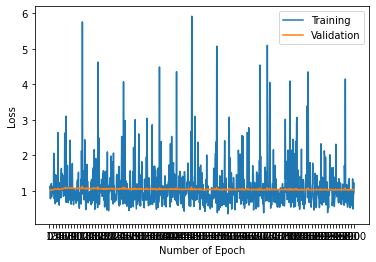

In [ ]:
fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)

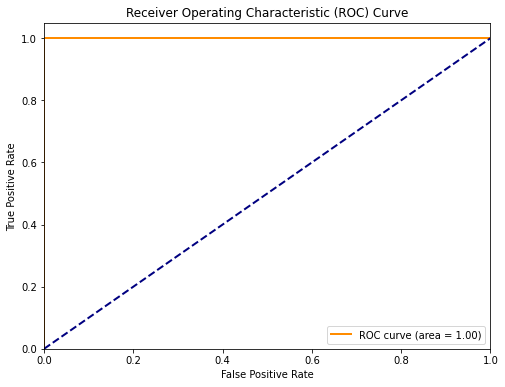

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()

143

In [16]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Fri Apr 12 09:23:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |  11511MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [17]:
def save_to_file(file_path, appendix, epoch, lr, dr, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, DR: {dr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-DR-{dr}')\n")
        
def hyper_params_test(appendix, lr, fc_dr=0.2,cnn_dr=0, epoch=50, l2=0):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    model = Original_Model(
    num_classes=5,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=50, # batch_size = 64
    num_dense_layers=3,
    return_logits=True,
    dense_dropout_rate=fc_dr,
    conv_dropout_rate=cnn_dr
    ).to(device)
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    

    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=8)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
    # criterion = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    

    ic.disable()
    # ic.enable()
        
    train_epoch_loss = []
    test_epoch_loss = []

    print(f'./graphs1/loss_lr_{lr}_SINGLE.png')

    for x, y in train_loader:
        x = x
        y = y
        break

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        
        # for x, y in train_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        # y_batch = y_batch.view(-1)

        # y_batch = one_hot_torch(y).to(device)
        # print('batch y size before flatten:',y_batch.size())
        # y_batch = y_batch.flatten()
        # print('batch y size after flatten:',y_batch.size())
        # print(x_batch.size())
        # print(x_batch.size())
    # For example, if you have a convolutional layer with 64 output channels, 3 input channels, and a kernel size of 3x3, the weight parameters would have a dimension of (64, 3, 3, 3)
        # print(x_batch.size())
        pred = model(x_batch.float())
        # print(x_batch)
        # print(pred)
        # pred = pred.unsqueeze(0)
        # ic(pred)
        # ic(y_batch)
        ic(pred.size())
        loss_train = criterion(pred, y_batch)
        ic(loss_train)
        train_batch_loss.append(loss_train)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # print(f'Batch - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB')

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('test')
            for x, y in test_loader:
                x_batch = x.to(device)
                y_batch = y.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())
                # pred = pred.unsqueeze(0)
                loss_test = criterion(pred, y_batch)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)      
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'./graphs1/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')
    save_to_file('trials.txt', appendix ,epoch, lr, fc_dr, train_epoch_loss, test_epoch_loss)
    print(f'./graphs1/{appendix}_loss_lr_{lr}_cnn_dr_{cnn_dr}_fc_dr_{fc_dr}.png')

lr: 0.001 | fc_dr: 0 | cnn_dr: 0 ==============================
./graphs1/loss_lr_0.001_SINGLE.png


100%|██████████| 400/400 [03:51<00:00,  1.73it/s]
/tmp/ipykernel_62552/2281237394.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/128-3-50_loss_lr_0.001_cnn_dr_0_fc_dr_0.png
lr: 0.001 | fc_dr: 0.2 | cnn_dr: 0 ==============================
./graphs1/loss_lr_0.001_SINGLE.png


100%|██████████| 400/400 [03:45<00:00,  1.77it/s]
/tmp/ipykernel_62552/2281237394.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/128-3-50_loss_lr_0.001_cnn_dr_0_fc_dr_0.2.png
lr: 0.001 | fc_dr: 0.3 | cnn_dr: 0 ==============================
./graphs1/loss_lr_0.001_SINGLE.png


100%|██████████| 400/400 [03:45<00:00,  1.78it/s]
/tmp/ipykernel_62552/2281237394.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/128-3-50_loss_lr_0.001_cnn_dr_0_fc_dr_0.3.png
lr: 0.001 | fc_dr: 0.4 | cnn_dr: 0 ==============================
./graphs1/loss_lr_0.001_SINGLE.png


100%|██████████| 400/400 [03:45<00:00,  1.77it/s]
/tmp/ipykernel_62552/2281237394.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/128-3-50_loss_lr_0.001_cnn_dr_0_fc_dr_0.4.png
lr: 0.001 | fc_dr: 0.5 | cnn_dr: 0 ==============================
./graphs1/loss_lr_0.001_SINGLE.png


100%|██████████| 400/400 [03:46<00:00,  1.77it/s]

./graphs1/128-3-50_loss_lr_0.001_cnn_dr_0_fc_dr_0.5.png



/tmp/ipykernel_62552/2281237394.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


TypeError: hyper_params_test() got multiple values for argument 'epoch'

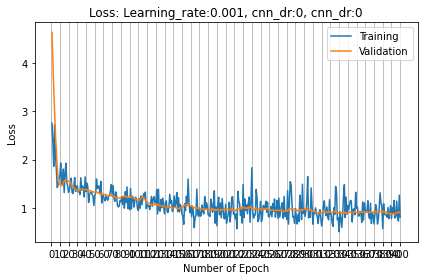

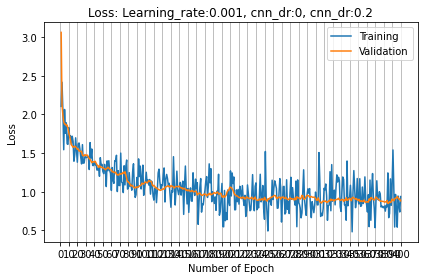

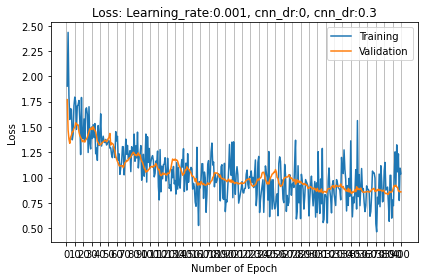

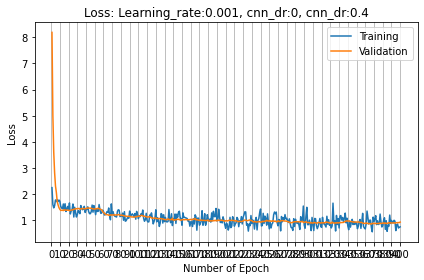

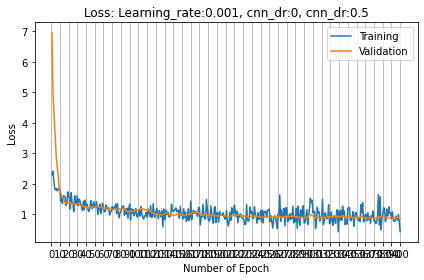

: 

In [18]:
epoch = 400
for lr in [0.001]:
    # for fc_dr in [:
    for fc_dr in [0, 0.2, 0.3, 0.4, 0.5]:
        for cnn_dr in [0]:
            hyper_params_test('128-3-50', lr, fc_dr, cnn_dr, epoch=epoch)
            
epoch = 400
for lr in [0.001]:
    # for fc_dr in [:
    for fc_dr in [0.2]:
        for l2 in [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]:
            for cnn_dr in [0]:
                hyper_params_test('128-3-50', lr, fc_dr, cnn_dr, l2, epoch=epoch)

lr: 0.004 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:21<00:00, 55.09s/it]


lr: 0.005 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:24<00:00, 55.23s/it]


lr: 0.007 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.66s/it]


lr: 0.008 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:10<00:00, 54.54s/it]


lr: 0.0085 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:20<00:00, 55.00s/it]


lr: 0.0095 | fc_dr: 0.2 | cnn_dr: 0 ==============================


100%|██████████| 20/20 [18:13<00:00, 54.69s/it]


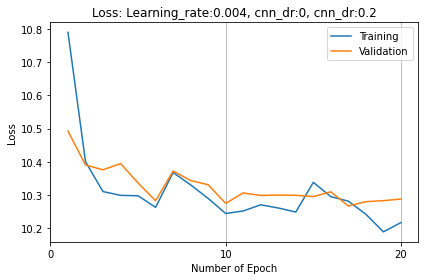

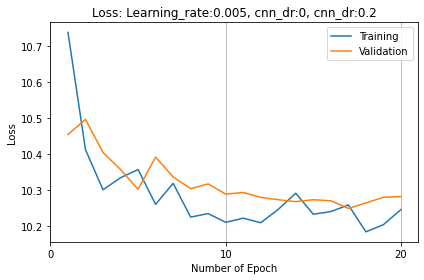

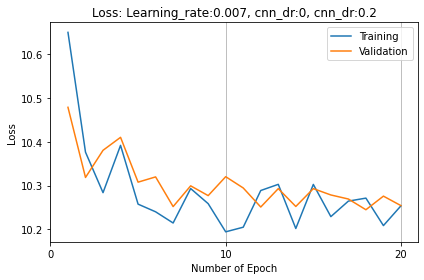

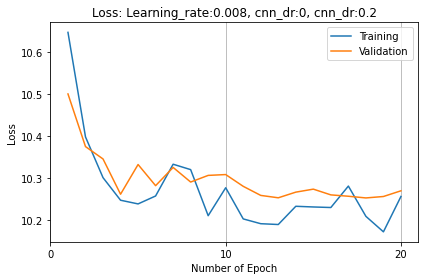

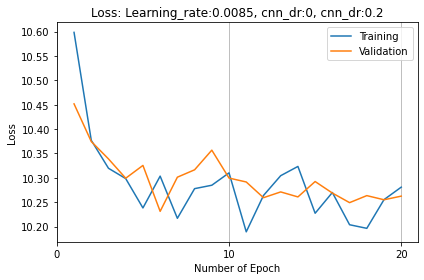

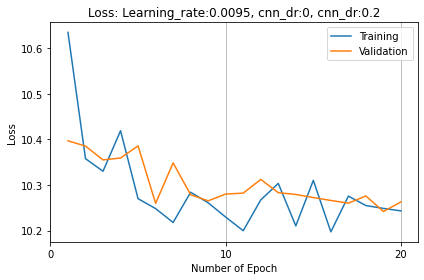

In [34]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

In [ ]:
# for x in np.arange(0.0000,0.0101,0.0005):
for x in [0.004,0.005, 0.007,0.008,0.0085, 0.0095]:
    if x == 0:
        continue
    else:
        hyper_params_test(x, epoch=20)

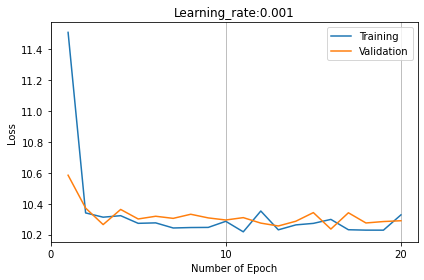

In [17]:
#%%
fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")